**Import all Necessary Libraries**

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from tensorflow import keras
from keras.models import Sequential
from keras.layers import Conv2D, Lambda, MaxPooling2D # convolution layers
from keras.layers import Dense, Dropout, Flatten # core layers
from keras.layers import BatchNormalization

from keras.preprocessing.image import ImageDataGenerator

from keras.utils.np_utils import to_categorical

#from keras.datasets import mnist

In [2]:
import os
print(os.listdir('../input'))

['digit-recognizer']


# 2. Data preparation
## 2.1 Load data

In [3]:
train = pd.read_csv('/kaggle/input/digit-recognizer/train.csv')
test = pd.read_csv('/kaggle/input/digit-recognizer/test.csv')
sub = pd.read_csv('/kaggle/input/digit-recognizer/sample_submission.csv')
print("Data are Ready!!")

Data are Ready!!


In [4]:
print(f"Training data size is {train.shape}\nTesting data size is {test.shape}")

Training data size is (42000, 785)
Testing data size is (28000, 784)


**Set data features and labels**

In [5]:
X = train.drop(['label'], 1).values
y = train['label'].values

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  """Entry point for launching an IPython kernel.


## 2.2 Normalization

We perform a grayscale normalization to reduce the effect of illumination's differences. 

Moreover the CNN converg faster on [0..1] data than on [0..255].

In [6]:
X = X / 255.0

## 2.3 Reshape

In [7]:
# Reshape image in 3 dimensions (height = 28px, width = 28px , canal = 1)
# canal = 1 => For gray scale
X = X.reshape(-1,28,28,1)

## 2.4 Label encoding

**One-Hot Encoding**

In [8]:
# Encode labels to one hot vectors (ex : 2 -> [0,0,1,0,0,0,0,0,0,0])
y = to_categorical(y)

print(f"Label size {y.shape}")

Label size (42000, 10)


Labels are 10 digits numbers from 0 to 9. We need to encode these lables to one hot vectors (ex : 2 -> [0,0,1,0,0,0,0,0,0,0]).

## 2.5 Split training and valdiation set

In [9]:
# Split the train and the validation set for the fitting
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)

In [10]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((37800, 28, 28, 1), (4200, 28, 28, 1), (37800, 10), (4200, 10))

**Data Visualization**

**Normalization**

In [11]:
mean = np.mean(X_train)
std = np.std(X_train)

def standardize(x):
    return (x-mean)/std

**Model Definition**

In [12]:
model=Sequential()

#model.add(Lambda(standardize,input_shape=(28,28,1)))    
model.add(Conv2D(filters=64, kernel_size = (3,3), activation="relu", input_shape=(28,28,1)))
model.add(Conv2D(filters=64, kernel_size = (3,3), activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(filters=128, kernel_size = (3,3), activation="relu"))
model.add(Conv2D(filters=128, kernel_size = (3,3), activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2)))  

model.add(Conv2D(filters=256, kernel_size = (3,3), activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2)))
    
model.add(Flatten())
model.add(Dense(512,activation="relu"))
    
model.add(Dense(10,activation="softmax"))
    
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

2022-12-12 14:17:31.201457: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-12 14:17:31.202432: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-12 14:17:31.352123: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-12 14:17:31.353034: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-12 14:17:31.353852: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

In [13]:
model2=Sequential()
model2.add(Lambda(standardize,input_shape=(28,28,1)))    
model2.add(Conv2D(filters=64, kernel_size = (3,3), activation="relu"))
model2.add(Conv2D(filters=64, kernel_size = (3,3), activation="relu"))
model2.add(MaxPooling2D(pool_size=(2,2)))
model2.add(BatchNormalization())

model2.add(Conv2D(filters=128, kernel_size = (3,3), activation="relu"))
model2.add(Conv2D(filters=128, kernel_size = (3,3), activation="relu"))
model2.add(MaxPooling2D(pool_size=(2,2)))
model2.add(BatchNormalization())    

model2.add(Conv2D(filters=256, kernel_size = (3,3), activation="relu"))
model2.add(MaxPooling2D(pool_size=(2,2)))
model2.add(BatchNormalization())
    
model2.add(Flatten())
model2.add(Dense(512,activation="relu"))
    
model2.add(Dense(10,activation="softmax"))
    
model2.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

## 3.2 Data augmentation

In [14]:
# With data augmentation to prevent overfitting

datagen = ImageDataGenerator(
        featurewise_center=False,
        samplewise_center=False,  
        featurewise_std_normalization=False,  
        samplewise_std_normalization=False,  
        zca_whitening=False,  
        rotation_range=15,  
        zoom_range = 0.01, 
        width_shift_range=0.1, 
        height_shift_range=0.1,
        horizontal_flip=False, 
        vertical_flip=False) 


#datagen.fit(X_train)
train_gen = datagen.flow(X_train, y_train, batch_size=128)
test_gen = datagen.flow(X_test, y_test, batch_size=128)

### Drive training phase
**EarlyStoping**: Stop training when a monitored metric has stopped improving.

**ReduceLROnPlateau**: Reduce learning rate when a metric has stopped improving.

In [15]:
epochs = 25
batch_size = 128
train_steps = X_train.shape[0] // batch_size
valid_steps = X_test.shape[0] // batch_size

es = keras.callbacks.EarlyStopping(
        monitor="val_acc", # metrics to monitor
        patience=10, # how many epochs before stop
        verbose=1,
        mode="max", # we need the maximum accuracy.
        restore_best_weights=True, # 
     )

rp = keras.callbacks.ReduceLROnPlateau(
        monitor="val_acc",
        factor=0.2,
        patience=3,
        verbose=1,
        mode="max",
        min_lr=0.00001,
     )

In [16]:
# Fit the model
history1 = model.fit(train_gen, epochs = epochs, 
                              steps_per_epoch = train_steps,
                              validation_data = test_gen,
                              validation_steps = valid_steps, 
                              callbacks=[es, rp])
history2 = model2.fit(train_gen,epochs = epochs, 
                              steps_per_epoch = train_steps,
                              validation_data = test_gen,
                              validation_steps = valid_steps, 
                              callbacks=[es, rp])

2022-12-12 14:17:35.600990: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/25


2022-12-12 14:17:37.729303: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


295/295 [==============================] - 23s 43ms/step - loss: 0.4009 - accuracy: 0.8705 - val_loss: 0.1058 - val_accuracy: 0.9673
Epoch 2/25
295/295 [==============================] - 13s 45ms/step - loss: 0.0845 - accuracy: 0.9748 - val_loss: 0.0825 - val_accuracy: 0.9736
Epoch 3/25
295/295 [==============================] - 13s 45ms/step - loss: 0.0615 - accuracy: 0.9816 - val_loss: 0.0656 - val_accuracy: 0.9790
Epoch 4/25
295/295 [==============================] - 14s 46ms/step - loss: 0.0507 - accuracy: 0.9843 - val_loss: 0.0506 - val_accuracy: 0.9834
Epoch 5/25
295/295 [==============================] - 13s 44ms/step - loss: 0.0439 - accuracy: 0.9865 - val_loss: 0.0404 - val_accuracy: 0.9875
Epoch 6/25
295/295 [==============================] - 13s 45ms/step - loss: 0.0391 - accuracy: 0.9880 - val_loss: 0.0527 - val_accuracy: 0.9836
Epoch 7/25
295/295 [==============================] - 13s 42ms/step - loss: 0.0335 - accuracy: 0.9898 - val_loss: 0.0391 - val_accuracy: 0.9885
Epo

**Plot CNN model**

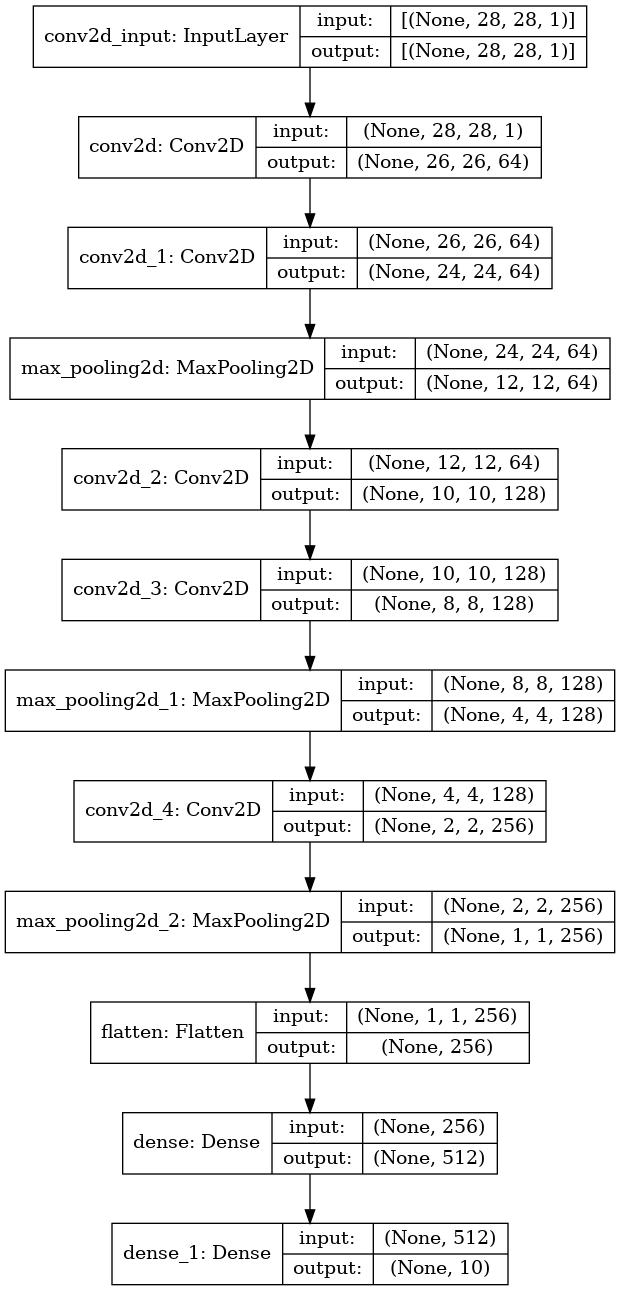

In [17]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='CNN_model_arch.png', show_shapes=True, show_layer_names=True)

# 4. Evaluate the model
## 4.1 Training and validation curves

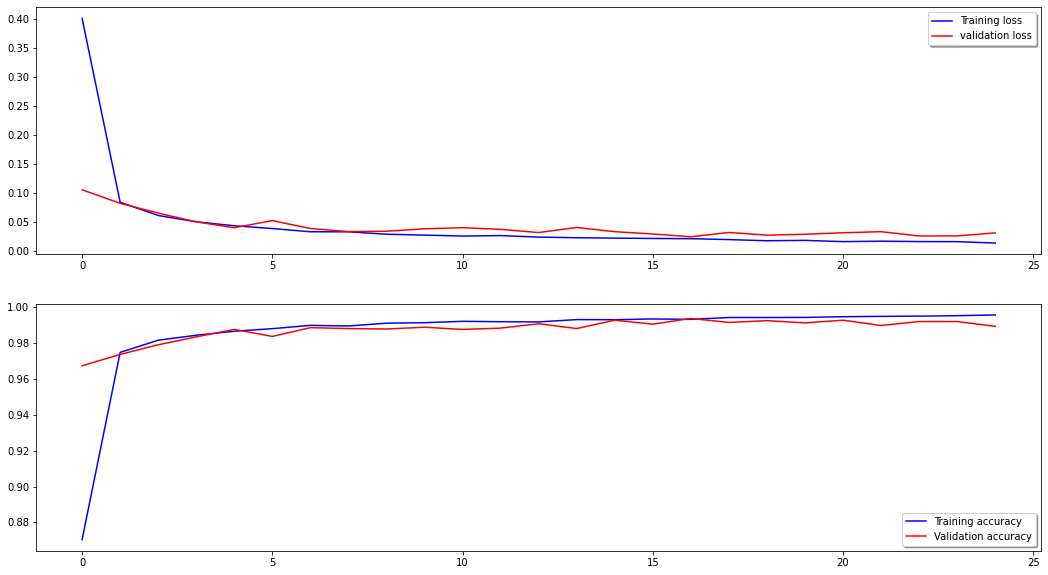

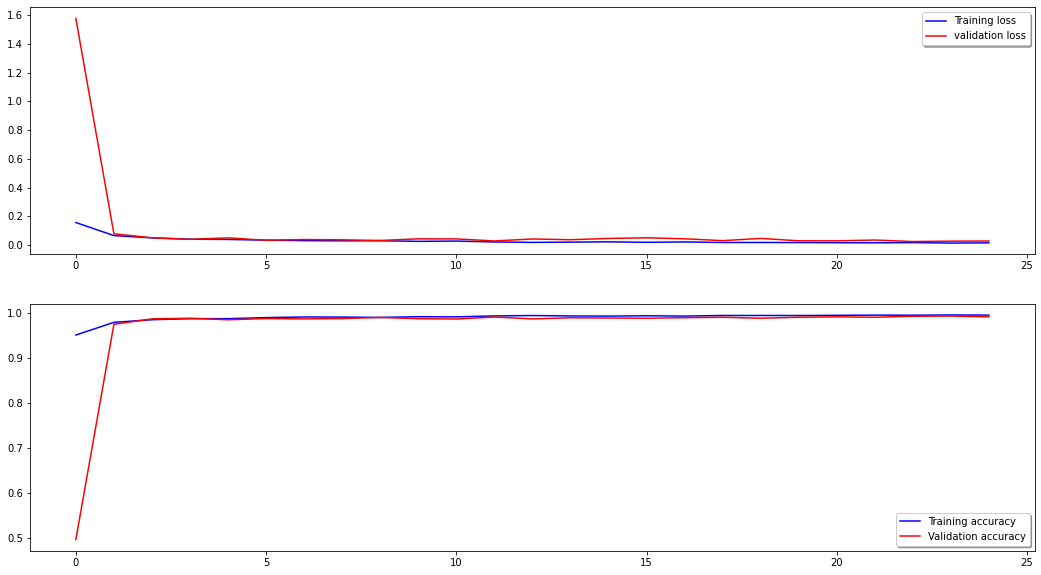

In [20]:
# Plot the loss and accuracy curves for training and validation 
fig, ax = plt.subplots(2,1, figsize=(18, 10))
ax[0].plot(history1.history['loss'], color='b', label="Training loss")
ax[0].plot(history1.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history1.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history1.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

fig, ax = plt.subplots(2,1, figsize=(18, 10))
ax[0].plot(history2.history['loss'], color='b', label="Training loss")
ax[0].plot(history2.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history2.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history2.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

## 4.2 Confusion matrix

Confusion matrix can be very helpfull to see your model drawbacks.

I plot the confusion matrix of the validation results.

In [ ]:
fig = plt.figure(figsize=(10, 10)) # Set Figure

y_pred = model.predict(X_test) # Predict class probabilities as 2 => [0.1, 0, 0.9, 0, 0, 0, 0, 0, 0, 0]

Y_pred = np.argmax(y_pred, 1) # Decode Predicted labels
Y_test = np.argmax(y_test, 1) # Decode labels

mat = confusion_matrix(Y_test, Y_pred) # Confusion matrix

# Plot Confusion matrix
sns.heatmap(mat.T, square=True, annot=True, cbar=False, cmap=plt.cm.Blues, fmt='.0f')
plt.xlabel('Predicted Values')
plt.ylabel('True Values');
plt.show();

# 5. Prediction and submition

## 5.1 Prediction validation results

In [ ]:
y_pred = model.predict(X_test)
X_test__ = X_test.reshape(X_test.shape[0], 28, 28)

fig, axis = plt.subplots(4, 4, figsize=(12, 14))
for i, ax in enumerate(axis.flat):
    ax.imshow(X_test__[i], cmap='binary')
    ax.set(title = f"Real Number is {y_test[i].argmax()}\nPredict Number is {y_pred[i].argmax()}");

## 5.2 Submition

**Prediciting test classes**

In [ ]:
# preprocess test data
test_x = test.values
test_x = test_x / 255.0
test_x = test_x.reshape(-1,28,28,1)

# predict test data
pred = model.predict_classes(test_x, verbose=1)

In [ ]:
# submissions
sub['Label'] = pred
sub.to_csv("CNN_keras_sub.csv", index=False)
sub.head()